In [1]:
import os
os.chdir(r'C:\Users\jf79\Repos\REAP-Analytics')

import myfuncs.myfuncs as mf
import repofuncs.reapmonthlyfuncs as rmf

import pandas as pd
from pandas.tseries.offsets import DateOffset
import calendar
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
path_to_data = r"C:\Users\jf79\OneDrive - Office Shared Service\Sharepoint Links\BI - Corporate - Documents\REAP\1. REAP Monthly Report 2025\Face to Face"
os.chdir(path_to_data)
legacy_data = pd.read_excel('Historical Data.xlsx')

In [3]:
path_to_data = os.path.join(path_to_data, 'Latest Visitations')
os.chdir(path_to_data)

mf.read_directory()

# Create an empty DataFrame to store the combined data
master_data = pd.DataFrame()

for file in os.listdir(path_to_data):
    if file.endswith(".xlsx"):  # Ensure it's a XLSX file
        file_path = os.path.join(path_to_data, file)

        # Read CSV
        df = pd.read_excel(file_path)

        # Add a new column with the CSV filename
        df["Source_File"] = file

        # Append to master DataFrame
        master_data = pd.concat([master_data, df], ignore_index=True)

master_data = mf.strip_dataframe(master_data)

Your Current Directory is: C:\Users\jf79\OneDrive - Office Shared Service\Sharepoint Links\BI - Corporate - Documents\REAP\1. REAP Monthly Report 2025\Face to Face\Latest Visitations
DataFrame: files
Number of records: 3 | Number of fields: 1
Number of unique duplicate records: 0 | Total number of duplicate records: 0


,File Names
0,145KS Visitor Enquiry Form(1-5000).xlsx
1,145KS Visitor Enquiry Form(10001-14832).xlsx
2,145KS Visitor Enquiry Form(5001-10000).xlsx


In [4]:
month_order = [
    'April','May','June','July','August','September','October','November',
    'December','January','February','March']

date_dic = rmf.obtain_relevant_dates(master_data, 'Completion time')

In [5]:
legacy_df = legacy_data.set_index('month')

master_data['Completion time'] = pd.to_datetime(master_data['Completion time'])
master_data = master_data[master_data['Completion time'].isna() == False]
master_data['month'] = master_data['Completion time'].dt.month.apply(lambda m: calendar.month_name[m])
master_data['tax_year'] = master_data['Completion time'].apply(
    lambda x: f'{str(x.year)[-2:]}-{str(x.year+1)[-2:]}'
    if x.month >= 4 
    else f'{str(x.year-1)[-2:]}-{str(x.year)[-2:]}'
)

visit_data = master_data[master_data['Completion time'] < pd.to_datetime(date_dic['prev_full_month'], format='%Y-%m') + DateOffset(months=1)]

visit_data = visit_data.groupby(['tax_year','month'])['ID'].count().reset_index()

visit_data = visit_data.pivot(
    index='month',
    columns='tax_year',
    values='ID'
).reindex(month_order).fillna(legacy_df)

mf.display(visit_data)

DataFrame: visit_data
Number of records: 12 | Number of fields: 3
Number of unique duplicate records: 0 | Total number of duplicate records: 0


tax_year,23-24,24-25,25-26
month,,,
April,809.0,862.0,389.0
May,840.0,897.0,232.0
June,730.0,754.0,522.0
July,760.0,787.0,801.0
August,770.0,745.0,863.0
September,782.0,695.0,NaN
October,886.0,780.0,NaN
November,1.0,740.0,NaN
December,327.0,512.0,NaN


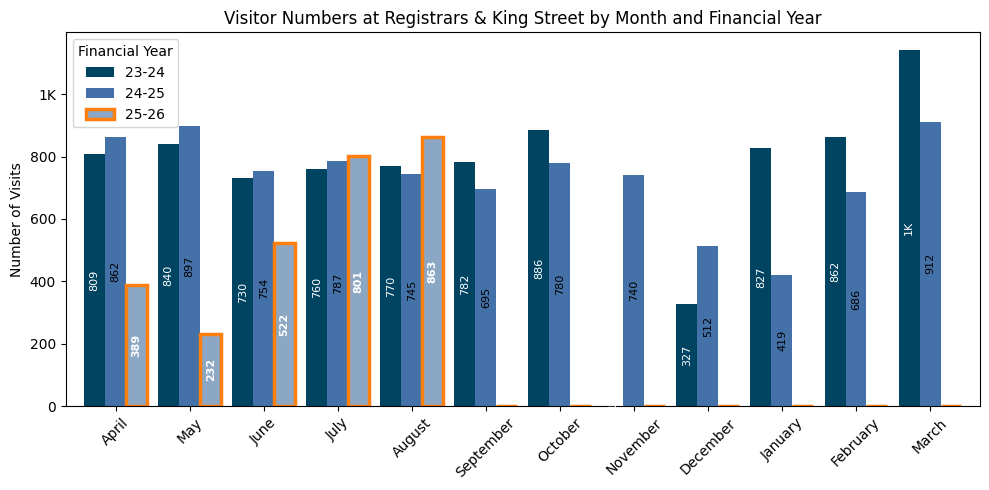

In [6]:
# Base colors
base_colors = ["#004c6d", "#4a7ebb", "#9bbad9", "#6b5b95"]
 
# Dynamically generate colors for however many year groups exist
n_years = len(visit_data.columns)
colors = []
for i in range(n_years):
    base = mcolors.to_rgb(base_colors[i % len(base_colors)])
    factor = 0.9 + 0.2 * (i // len(base_colors))  # lighten/darken cycles
    colors.append(tuple(np.clip([c * factor for c in base], 0, 1)))
 
# Plot grouped bar chart
ax = visit_data.plot(kind='bar', figsize=(10,5), width=0.85, color=colors)
 
# Highlight the last year group with a standout outline
highlight_edge = "#ff7f0e"  # bright orange outline
for patch in ax.containers[-1]:  # last year group bars
    patch.set_edgecolor(highlight_edge)
    patch.set_linewidth(2.5)
 
# Alternate label colors (white/black)
label_colors = ["white" if i % 2 == 0 else "black" for i in range(n_years)]
 
# Add labels in the center of bars, omit zeros
for idx, container in enumerate(ax.containers):
    labels = []
    for v in container.datavalues:
        if v == 0 or np.isnan(v):
            labels.append("")
        elif v >= 1000:
            labels.append(f"{int(v/1000)}K")
        else:
            labels.append(str(int(v)))
    # Bold labels only for the last year group
    weight_style = "bold" if idx == n_years - 1 else "normal"
    ax.bar_label(container, labels=labels, label_type='center',
                 fontsize=8, color=label_colors[idx],
                 weight=weight_style, rotation=90)
 
# Format y-axis labels with K
ax.set_yticklabels([f"{int(y/1000)}K" if y >= 1000 else int(y) for y in ax.get_yticks()])
ax.set_xlabel("")
 
plt.ylabel('Number of Visits')
plt.title('Visitor Numbers at Registrars & King Street by Month and Financial Year')
plt.xticks(rotation=45)
plt.legend(title='Financial Year')
plt.tight_layout()
plt.show()